In [2]:
#Libraries for classifying and modeling data
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [42]:
options(repr.matrix.max.rows = 6)

#Read dataset from the repository
cleveland_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

#Make column names readable
colnames(cleveland_disease_data) <- c("Age", "Sex", "Type_Chest_Pain", "Resting_Blood_Pressure", "Cholestorol", "Fasting_Blood_Sugar", "Resting_ECG_Results", 
                                         "Max_Heart_Rate", "Exercise_Angina", "ST_Depression_Exercise", "Slope", "Major_Vessels", "Thalassemia", "Diagnosis") 

cleveland_tidy_data <- cleveland_disease_data |>
    mutate(Diagnosis = case_when(Diagnosis != 0 ~ "Positive",
                                 Diagnosis == 0 ~ "Negative")) |>
    mutate(Diagnosis = as.factor(Diagnosis))

cleveland_tidy_data

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,Type_Chest_Pain,Resting_Blood_Pressure,Cholestorol,Fasting_Blood_Sugar,Resting_ECG_Results,Max_Heart_Rate,Exercise_Angina,ST_Depression_Exercise,Slope,Major_Vessels,Thalassemia,Diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,Positive
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,Positive
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,Positive
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,Positive
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,Negative


In [43]:
set.seed(2000)
#Splitting data into training and testing datasets
cleveland_split <- initial_split(cleveland_tidy_data, prop = 0.75, strata = Diagnosis)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

Age,Sex,Type_Chest_Pain,Resting_Blood_Pressure,Cholestorol,Fasting_Blood_Sugar,Resting_ECG_Results,Max_Heart_Rate,Exercise_Angina,ST_Depression_Exercise,Slope,Major_Vessels,Thalassemia,Diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,Negative
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,Negative
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,Negative
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,Negative
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,Negative
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,Negative


In [44]:
cleveland_summary_data <- cleveland_training |>
                        group_by(Diagnosis) |>
                        summarize(Mean_Age = mean(Age),
                                  Mean_RBP = mean(Resting_Blood_Pressure),
                                  Mean_Chol = mean(Cholestorol),
                                  Mean_MHR = mean(Max_Heart_Rate),
                                  Mean_STDE = mean(ST_Depression_Exercise),
                                 No._Patients = n())
cleveland_summary_data             

Diagnosis,Mean_Age,Mean_RBP,Mean_Chol,Mean_MHR,Mean_STDE,No._Patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Negative,52.54098,128.1639,243.6885,157.7623,0.6188525,122
Positive,56.99038,133.5673,248.5385,139.1346,1.5605769,104


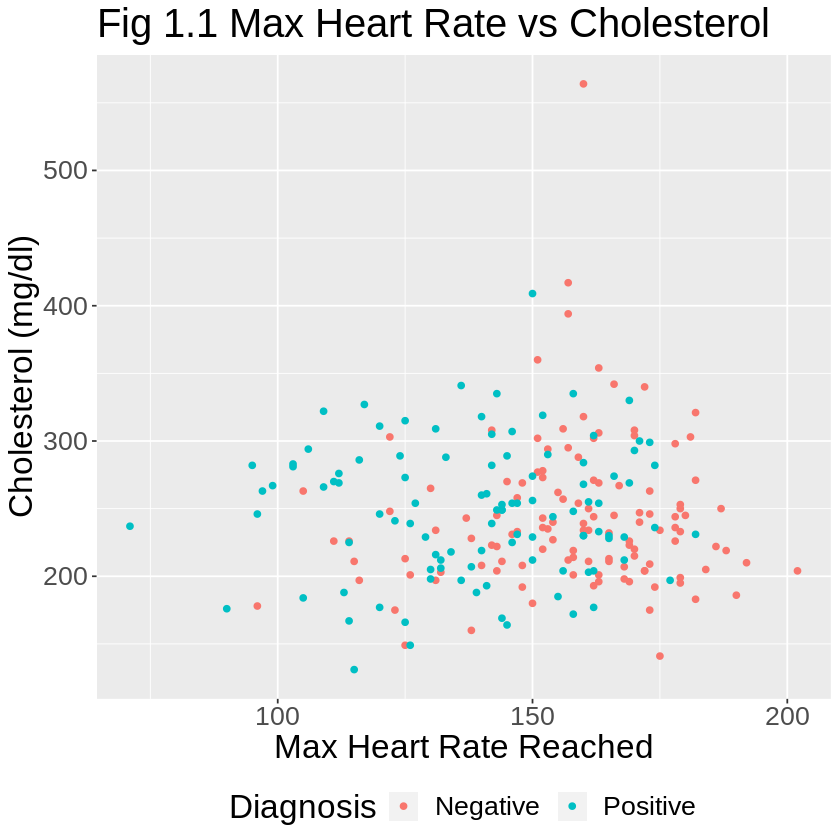

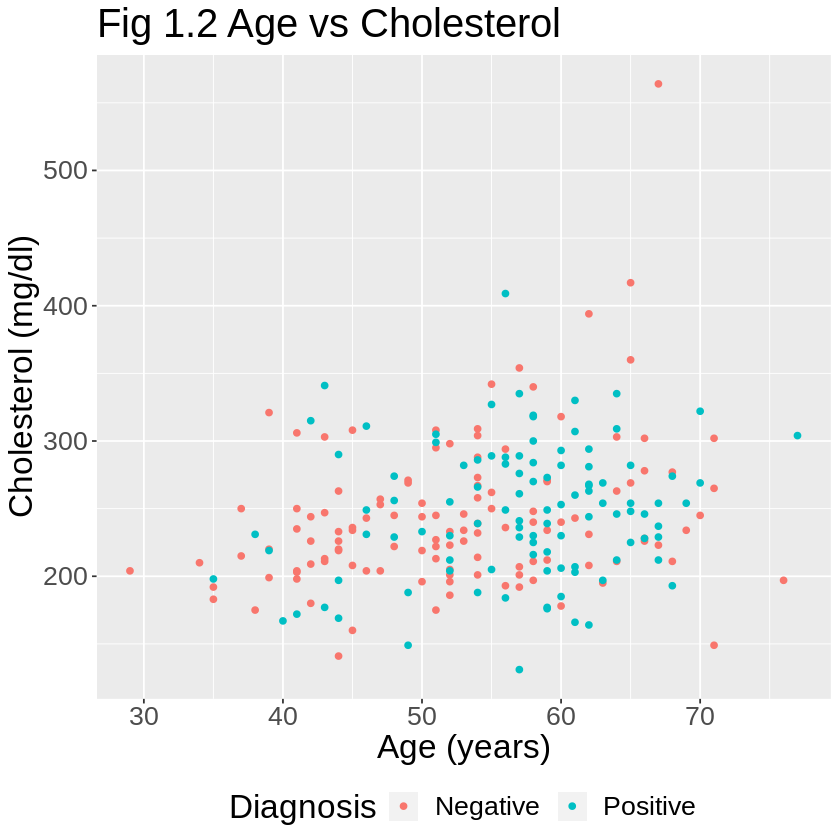

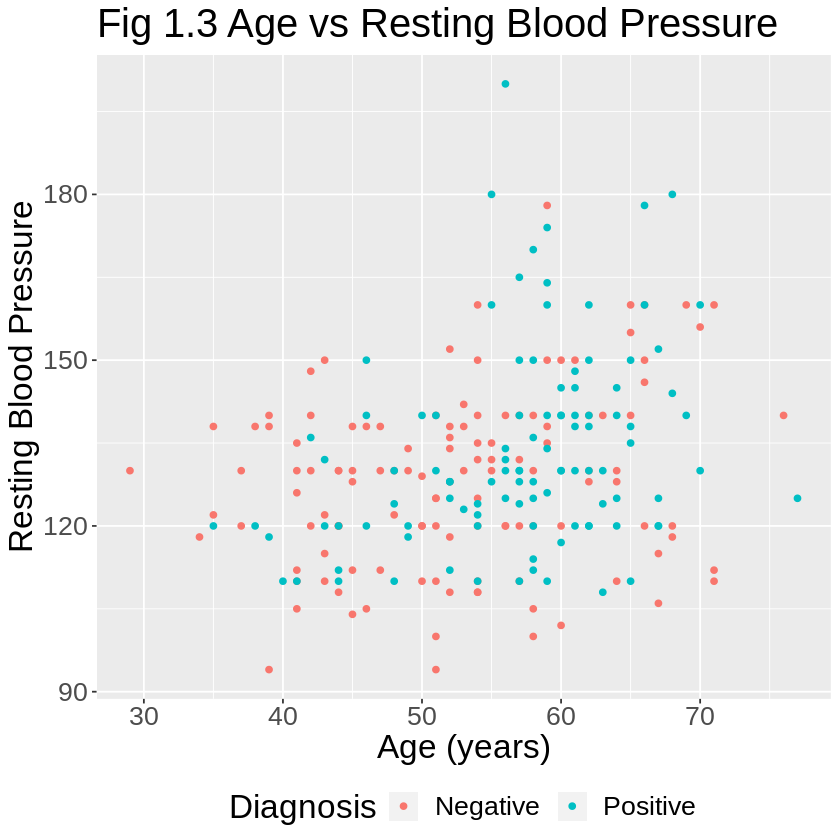

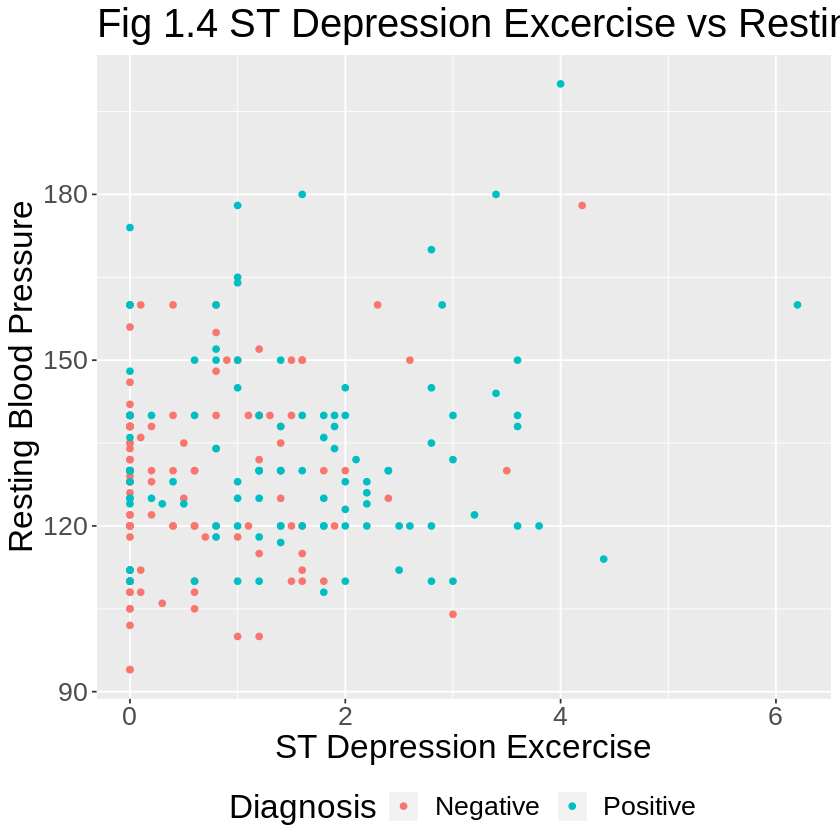

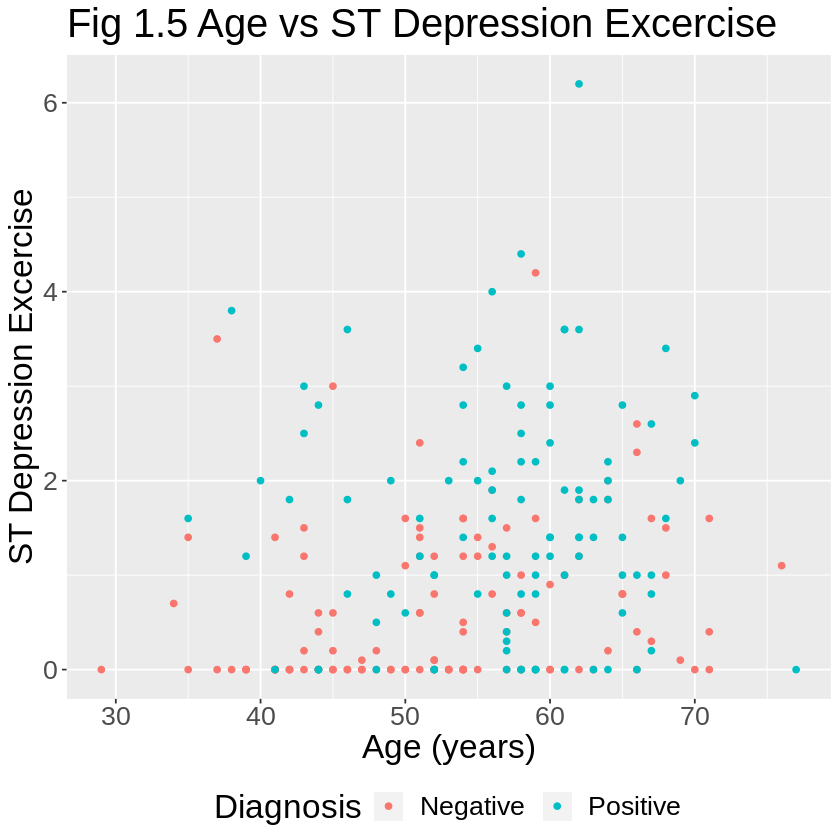

In [61]:
prop_plot1 <- ggplot(cleveland_training, aes(x = Max_Heart_Rate, y = Cholestorol, color = Diagnosis)) +
                 geom_point() +
                 labs(x = "Max Heart Rate Reached", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 ggtitle("Fig 1.1 Max Heart Rate vs Cholesterol") +
                 theme(text = element_text(size = 20), legend.position = "bottom")
                

prop_plot2 <- ggplot(cleveland_training, aes(x = Age, y = Cholestorol, color = Diagnosis)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 ggtitle("Fig 1.2 Age vs Cholesterol") +
                 theme(text = element_text(size = 20), legend.position = "bottom")     

prop_plot3 <- ggplot(cleveland_training, aes(x = Age, y = Resting_Blood_Pressure, color = Diagnosis)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "Resting Blood Pressure", color = "Diagnosis") +
                 ggtitle("Fig 1.3 Age vs Resting Blood Pressure") +
                 theme(text = element_text(size = 20), legend.position = "bottom")

prop_plot4 <- ggplot(cleveland_training, aes(x = ST_Depression_Exercise, y = Resting_Blood_Pressure, color = Diagnosis)) +
                 geom_point() +
                 labs(x = "ST Depression Excercise", y = "Resting Blood Pressure", color = "Diagnosis") +
                 ggtitle("Fig 1.4 ST Depression Excercise vs Resting Blood Pressure") +
                 theme(text = element_text(size = 20), legend.position = "bottom")

prop_plot5 <- ggplot(cleveland_training, aes(x = Age, y = ST_Depression_Exercise, color = Diagnosis)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "ST Depression Excercise", color = "Diagnosis") +
                 ggtitle("Fig 1.5 Age vs ST Depression Excercise") +
                 theme(text = element_text(size = 20), legend.position = "bottom")
                 
prop_plot1
prop_plot2
prop_plot3
prop_plot4
prop_plot5